In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter(action='ignore', category=ValueWarning)

In [60]:
# Read in the RM crop yields data
df = pd.read_csv('data/rm-yields-data.csv')

In [61]:
#create a new dataframe that contains the mean yield for each crop in each RM
df_merged = df

In [62]:
def impute_missing_values(df, rm, column_name):
    # Subset the DataFrame to the current RM and column
    rm_df = df[(df['RM'] == rm) & df[column_name].notnull()]
    # Calculate the mean of the non-missing values for the specified column
    mean_value = rm_df[column_name].mean()
    # Replace missing values in the specified column with the mean of the non-missing values
    df.loc[(df['RM'] == rm) & df[column_name].isnull(), column_name] = mean_value
    # Return the DataFrame with missing values imputed for the specified column
    return df
# Define a list of column names with missing values
columns_with_missing_values = ['Winter Wheat', 'Canola', 'Spring Wheat', 'Mustard', 'Durum', 'Sunflowers', 'Oats', 'Lentils', 'Peas', 'Barley', 'Fall Rye', 'Canary Seed', 'Spring Rye', 'Tame Hay', 'Flax', 'Chickpeas']

# Loop through each RM and column with missing values and impute the missing values with the mean of the non-missing values for that column
for rm in df_merged['RM'].unique():
    for column_name in columns_with_missing_values:
        df_merged = impute_missing_values(df_merged, rm, column_name)

df_merged.fillna(0, inplace=True)

In [63]:
# adjust the decimal places to 2
df_merged = df_merged.round(1)

In [64]:
print(df_merged.isna().sum())
# Check for missing values
print("Missing values:", df_merged.isnull().sum().sum())

# Check for duplicates
print("Number of duplicates:", df_merged.duplicated().sum())

Year            0
RM              0
Winter Wheat    0
Canola          0
Spring Wheat    0
Mustard         0
Durum           0
Sunflowers      0
Oats            0
Lentils         0
Peas            0
Barley          0
Fall Rye        0
Canary Seed     0
Spring Rye      0
Tame Hay        0
Flax            0
Chickpeas       0
dtype: int64
Missing values: 0
Number of duplicates: 0


In [65]:
df = df_merged

In [66]:
unique_rms = df['RM'].unique()

In [67]:
time_series_results = {}

for rm in unique_rms:
    rm_data = df[df['RM'] == rm].sort_values(by='Year')
    rm_data.set_index('Year', inplace=True)
    rm_data.drop(columns=['RM'], inplace=True)
    
    # Calculate the rolling mean for each crop with a window of 3 years
    rolling_mean = rm_data.rolling(window=3).mean()
    
    # Store the result in a dictionary
    time_series_results[rm] = rolling_mean


In [68]:
def plot_rm_time_series(rm, time_series_data, crops):
    rm_data = time_series_data[rm]
    
    plt.figure(figsize=(12, 8))
    
    for crop in crops:
        plt.plot(rm_data.index, rm_data[crop], label=crop)
        
    plt.xlabel('Year')
    plt.ylabel('Yield')
    plt.title(f'Time Series for RM {rm}')
    plt.legend()
    plt.show()


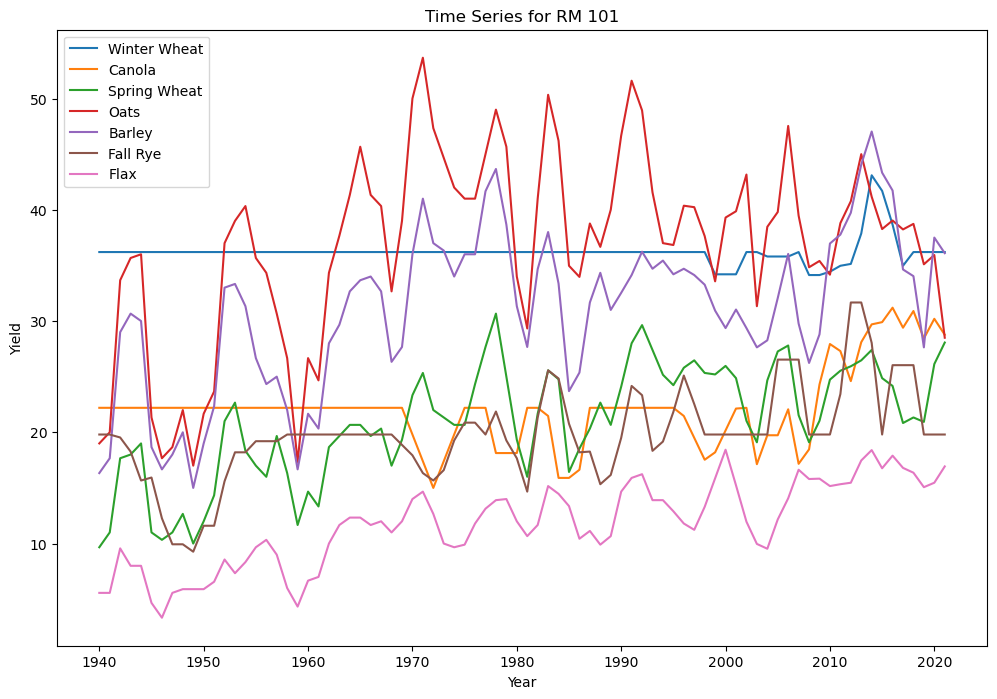

In [69]:
# Select the crops you want to visualize
selected_crops = ['Winter Wheat', 'Canola', 'Spring Wheat', 'Oats', 'Barley', 'Fall Rye', 'Flax']
RMNO = 101

# Call the function to plot the time series for a specific RM
plot_rm_time_series(RMNO, time_series_results, selected_crops)


In [70]:
from statsmodels.tsa.seasonal import STL

In [71]:
def stl_decomposition_fillna(series, period, seasonal=7):
    # Remove rows with missing values temporarily for STL decomposition
    series_temp = series.dropna()
    
    # Perform STL decomposition
    stl = STL(series_temp, period=period, seasonal=seasonal)
    result = stl.fit()
    
    # Calculate the fitted values (trend + seasonal)
    fitted_values = result.trend + result.seasonal
    
    # Fill missing values in the original series with fitted values
    filled_series = series.copy()
    filled_series[series.isna()] = fitted_values[series.isna()]
    
    return filled_series


In [72]:
time_series_filled_results = {}

for rm in unique_rms:
    rm_data = df[df['RM'] == rm].sort_values(by='Year')
    rm_data.set_index('Year', inplace=True)
    rm_data.drop(columns=['RM'], inplace=True)
    
    filled_rm_data = pd.DataFrame()
    
    for crop in rm_data.columns:
        filled_series = stl_decomposition_fillna(rm_data[crop], period=3)
        filled_rm_data[crop] = filled_series
    
    time_series_filled_results[rm] = filled_rm_data


In [73]:
# Select the crops you want to visualize
selected_crops = ['Winter Wheat', 'Canola', 'Spring Wheat', 'Oats', 'Barley', 'Fall Rye', 'Flax']
RMNO = 588

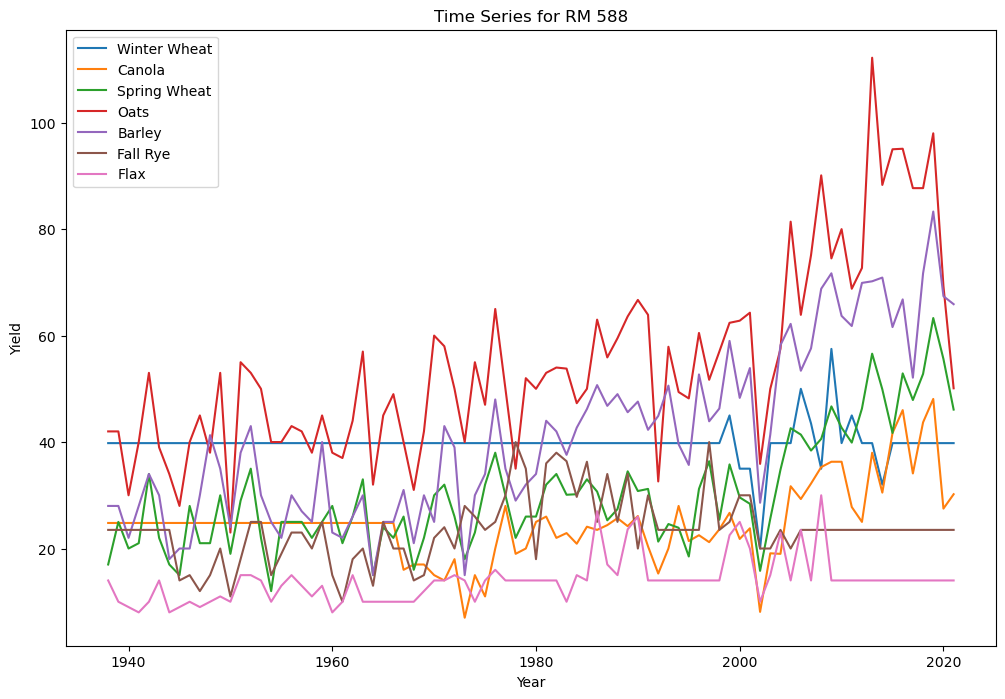

In [74]:

# Call the function to plot the time series for a specific RM using the filled data
plot_rm_time_series(RMNO, time_series_filled_results, selected_crops)


Trend Analysis: Calculate the slope of the linear regression line to identify the trend.

In [75]:
from scipy.stats import linregress

def trend_analysis(series):
    x = np.arange(len(series))
    y = series.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

for crop in selected_crops:
    rm_data = time_series_filled_results[RMNO][crop]
    trend = trend_analysis(rm_data)
    print(f'Trend for {crop}: {"Increasing" if trend > 0 else "Decreasing" if trend < 0 else "Stationary"}')


Trend for Winter Wheat: Increasing
Trend for Canola: Increasing
Trend for Spring Wheat: Increasing
Trend for Oats: Increasing
Trend for Barley: Increasing
Trend for Fall Rye: Increasing
Trend for Flax: Increasing


Seasonal Analysis: Use the seasonal component from the STL decomposition.

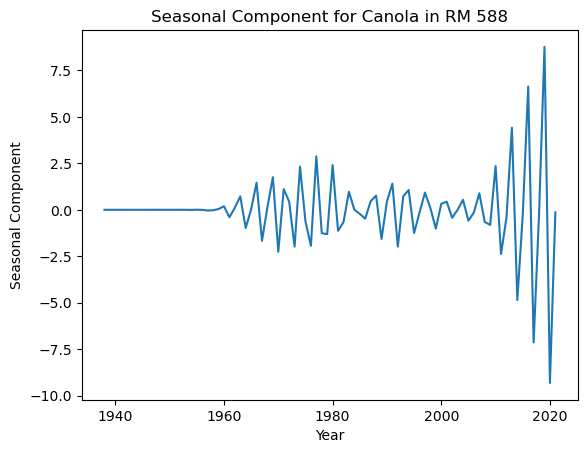

In [76]:
def plot_seasonal_component(rm, crop):
    series = time_series_filled_results[rm][crop].dropna()
    stl = STL(series, period=3)
    result = stl.fit()
    
    plt.plot(series.index, result.seasonal)
    plt.xlabel('Year')
    plt.ylabel('Seasonal Component')
    plt.title(f'Seasonal Component for {crop} in RM {rm}')
    plt.show()

plot_seasonal_component(RMNO, 'Canola')


Autocorrelation Analysis: Use the plot_acf function from statsmodels.

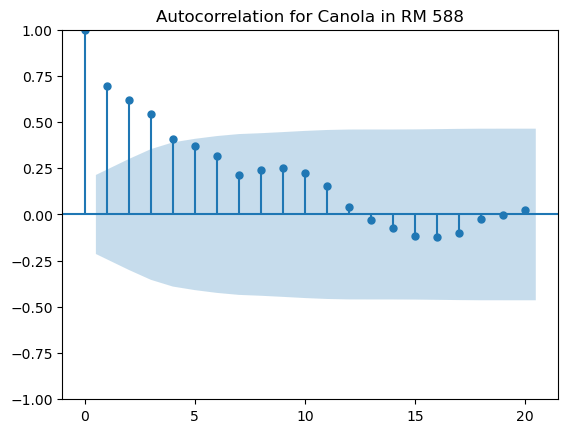

In [77]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorrelation(rm, crop):
    series = time_series_filled_results[rm][crop]
    plot_acf(series, title=f'Autocorrelation for {crop} in RM {rm}')
    plt.show()

plot_autocorrelation(RMNO, 'Canola')


Forecasting: Fit an ARIMA model and forecast future crop yields. You can adjust the model order and seasonal order based on your data's characteristics.

In [78]:
filtered_df = df[(df['Year'] >= 1938) & (df['Year'] <= 2021)]

In [79]:
time_series_filled_results = {}

for rm in unique_rms:
    rm_data = filtered_df[filtered_df['RM'] == rm].sort_values(by='Year')
    rm_data.set_index('Year', inplace=True)
    rm_data.drop(columns=['RM'], inplace=True)
    
    filled_rm_data = pd.DataFrame()
    
    for crop in rm_data.columns:
        filled_series = stl_decomposition_fillna(rm_data[crop], period=3)
        filled_rm_data[crop] = filled_series
    
    time_series_filled_results[rm] = filled_rm_data

81.69655152046451

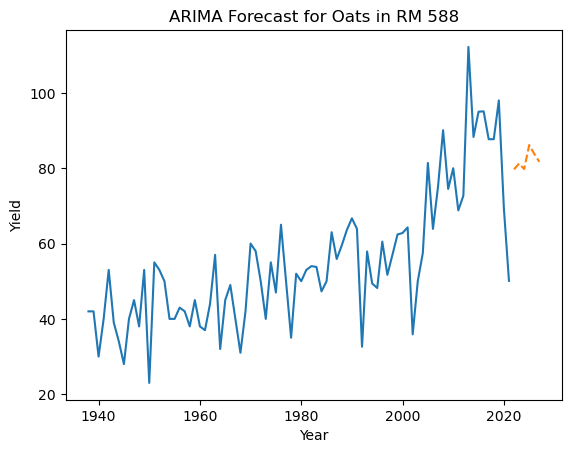

In [97]:
def forecast_arima(rm, crop, start_year=2022, end_year=2027, order=(1, 1, 1), seasonal_order=(0, 1, 1, 3)):
    series = time_series_filled_results[rm][crop]
    steps = end_year - start_year + 1
    
    if series.index[-1] >= start_year:
        print(f"Data already covers the years up to {series.index[-1]}. Forecasting from {series.index[-1] + 1} to {end_year}.")
        steps = end_year - series.index[-1]
    
    model = ARIMA(series, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    
    
    plt.plot(series.index, series.values, label='Observed')
    plt.plot(np.arange(series.index[-1] + 1, end_year + 1), forecast, label='Forecasted', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Yield')
    plt.title(f'ARIMA Forecast for {crop} in RM {rm}')
    #plt.legend()
    plt.savefig(f'arima_forecast_RM_{rm}_Crop_{crop}.png', dpi=300)
    #plt.show()

    # Return the forecast value
    return forecast.iloc[-1]

forecast_arima(RMNO, 'Oats')



38.462188114647546

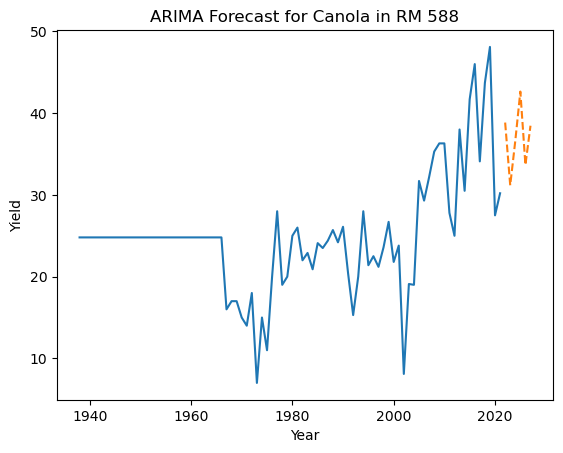

In [98]:
forecast_arima(RMNO, 'Canola')


In [81]:
unique_rms = df['RM'].unique()
crops = ['Winter Wheat', 'Canola', 'Spring Wheat', 'Oats', 'Barley', 'Fall Rye', 'Flax']

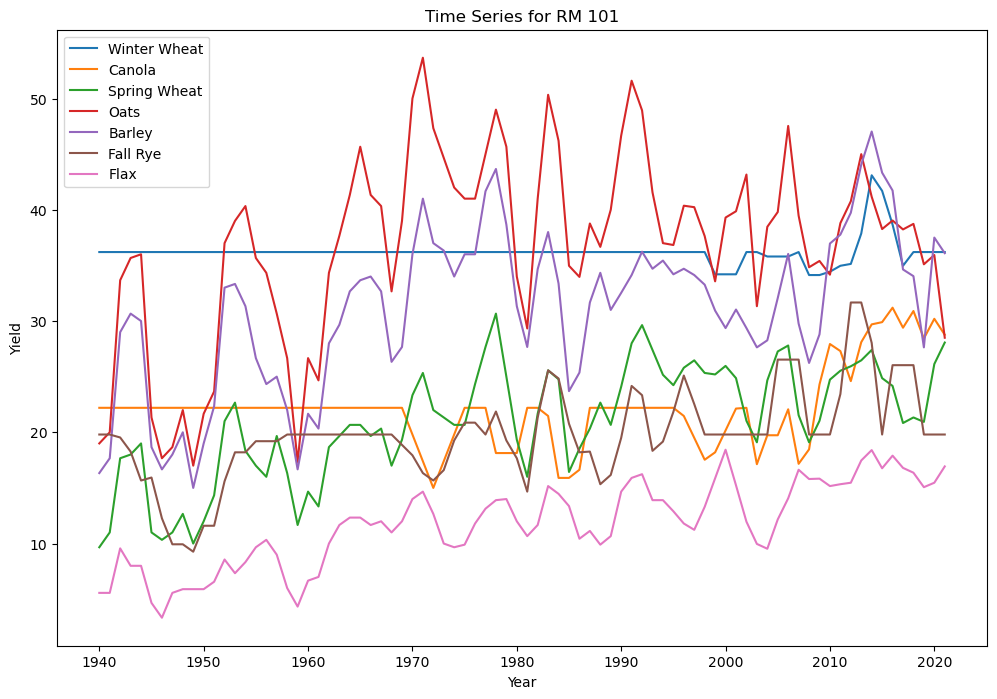

In [82]:
#fill the missing values in the time series data with the mean of the crop in the RM

for rm in unique_rms:
    for crop in selected_crops:
        time_series_results[rm][crop] = stl_decomposition_fillna(time_series_results[rm][crop], 3)

# Plot the time series again to see the difference
plot_rm_time_series(101, time_series_results, selected_crops)

Evaluate the ARIMA model: You can use the train_test_split method to create a training set and a testing set. Fit the model to the training set and then generate predictions for the testing set. Compare the predictions to the actual values using performance metrics like MAE, MSE, or RMSE. Here's an example of how to do this:

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def evaluate_arima_model(rm, crop, train_ratio=0.8, order=(1, 1, 1), seasonal_order=(0, 1, 1, 3)):
    series = time_series_filled_results[rm][crop]
    series = series.interpolate()  # Fill missing values using interpolation
    split_point = int(len(series) * train_ratio)
    train, test = series[:split_point], series[split_point:]

    model = ARIMA(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    
    return mae, mse, rmse

mae, mse, rmse = evaluate_arima_model(101, 'Canola')
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)



MAE: 8.459595097260252
MSE: 93.07157731042291
RMSE: 9.647361157872286


Compare different models: To compare different models, follow a similar procedure as above but fit the different models (ETS, STL, and Prophet) to the training set and generate predictions for the testing set. Calculate the performance metrics for each model and compare them to find the best model for your data.

In [84]:
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [85]:
def train_test_split(series, train_ratio=0.8):
    split_point = int(len(series) * train_ratio)
    train, test = series[:split_point], series[split_point:]
    return train, test


In [86]:
def evaluate_ets_model(train, test):
    model = ETSModel(train, seasonal_periods=3, trend='add', seasonal=None)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    
    return mae, mse, rmse


In [87]:
def evaluate_stl_model(train, test):
    stlf = STL(train, auto_arima, seasonal='add')
    model_fit = stlf.fit()
    predictions = model_fit.forecast(steps=len(test))
    
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    
    return mae, mse, rmse


In [88]:
def evaluate_prophet_model(train, test):
    train_df = pd.DataFrame({'ds': train.index, 'y': train.values})
    test_df = pd.DataFrame({'ds': test.index, 'y': test.values})

    model = Prophet()
    model.fit(train_df)
    forecast = model.predict(test_df)
    predictions = forecast['yhat'].values
    
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    
    return mae, mse, rmse


In [102]:
rm, crop = RMNO, 'Canola'
series = time_series_filled_results[rm][crop]
train, test = train_test_split(series)

ets_mae, ets_mse, ets_rmse = evaluate_ets_model(train, test)
#stl_mae, stl_mse, stl_rmse = evaluate_stl_model(train, test)
#prophet_mae, prophet_mse, prophet_rmse = evaluate_prophet_model(train, test)

print("ETS - MAE:", ets_mae, "MSE:", ets_mse, "RMSE:", ets_rmse)
#print("STL - MAE:", stl_mae, "MSE:", stl_mse, "RMSE:", stl_rmse)
#print("Prophet - MAE:", prophet_mae, "MSE:", prophet_mse, "RMSE:", prophet_rmse)



ETS - MAE: 17.64688828913555 MSE: 356.54260717480656 RMSE: 18.882335850598743


In [40]:
import pandas as pd

def analyze_rm_and_crop(rm, crop):
    try:
        mae, mse, rmse = evaluate_arima_model(rm, crop)
        return {"RM": rm, "Crop": crop, "MAE": mae, "MSE": mse, "RMSE": rmse}
    except Exception as e:
        print(f"Error for RM {rm}, Crop {crop}: {e}")
        return None

results = []
for rm in unique_rms:
    for crop in crops:
        result = analyze_rm_and_crop(rm, crop)
        if result is not None:
            results.append(result)

results_df = pd.DataFrame(results)
#results_df.to_csv("forecasting_results.csv", index=False)


c:\Users\jason\anaconda3\envs\playground\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jason\anaconda3\envs\playground\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jason\anaconda3\envs\playground\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jason\anaconda3\envs\playground\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

In [93]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [ ]:
def aggregate_forecasts(region=None, crop=None):
    forecasts = {}
    for rm in unique_rms:
        for c in crops:
            if (region is None or rm == region) and (crop is None or c == crop):
                # Use the ARIMA forecast function you defined earlier
                forecast = forecast_arima(rm, c)
                key = f"RM{rm}" if region else f"{c}"
                if key in forecasts:
                    forecasts[key] += forecast
                else:
                    forecasts[key] = forecast
    return forecasts

# Example usage
region_aggregate = aggregate_forecasts(region=RMNO)
crop_aggregate = aggregate_forecasts(crop='Canola')
all_aggregates = aggregate_forecasts()

# Save the aggregated forecasts to a CSV file
region_agg_df = pd.DataFrame(region_aggregate, index=[0])
#region_agg_df.to_csv('region_aggregate.csv', index=False)

crop_agg_df = pd.DataFrame(crop_aggregate, index=[0])
#crop_agg_df.to_csv('crop_aggregate.csv', index=False)

all_agg_df = pd.DataFrame(all_aggregates, index=[0])
#all_agg_df.to_csv('all_aggregates.csv', index=False)




Analyzing RM: 1, Crop: Winter Wheat
Analyzing RM: 1, Crop: Canola
Analyzing RM: 1, Crop: Spring Wheat
Analyzing RM: 1, Crop: Oats
Analyzing RM: 1, Crop: Barley
Analyzing RM: 1, Crop: Fall Rye
Analyzing RM: 1, Crop: Flax
Analyzing RM: 2, Crop: Winter Wheat
Analyzing RM: 2, Crop: Canola
Analyzing RM: 2, Crop: Spring Wheat
Analyzing RM: 2, Crop: Oats


KeyboardInterrupt: 

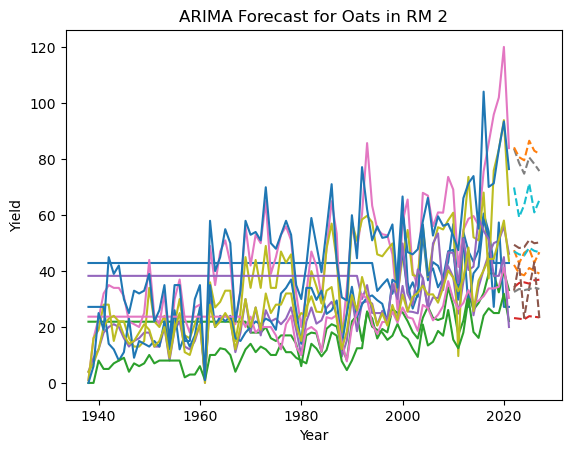

In [95]:
for rm in unique_rms:
    for crop in crops:
        print(f"Analyzing RM: {rm}, Crop: {crop}")
        # Perform the analysis and forecasting for each crop and RM combination
        # Replace `your_function` with the function you want to apply
        forecast_arima(rm, crop)



Perform sensitivity analysis: To perform sensitivity analysis, you can use grid search to test different combinations of parameters for your model. For example, you can test different values for p, d, and q in the ARIMA model and compare the performance metrics to find the best combination.

Analyze other crops and RMs: Iterate through the different RMs and crops in your dataset and apply the same analysis and forecasting techniques. This will give you a comprehensive view of the performance and trends across different crops and regions.

Aggregate forecasts: After generating forecasts for each RM and crop, you can aggregate the results by summing up the forecasts for each RM and crop to get a total forecast for a specific region or crop. You can do this using a loop or other aggregation techniques in Python.

By following these steps, you will be able to conduct a comprehensive time series analysis of crop yields in Saskatchewan. Don't forget to document your findings and insights as you progress through the analysis.

In [103]:
def forecast_arima(rm, crop, start_year=2022, end_year=2027, order=(1, 1, 1), seasonal_order=(0, 1, 1, 3)):
    series = time_series_filled_results[rm][crop]
    steps = end_year - start_year + 1
    
    if series.index[-1] >= start_year:
        print(f"Data already covers the years up to {series.index[-1]}. Forecasting from {series.index[-1] + 1} to {end_year}.")
        steps = end_year - series.index[-1]
    
    model = ARIMA(series, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    
    plt.plot(series.index, series.values, label='Observed')
    plt.plot(np.arange(series.index[-1] + 1, end_year + 1), forecast, label='Forecasted', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Yield')
    plt.title(f'ARIMA Forecast for {crop} in RM {rm}')
    plt.legend()
    plt.savefig(f'arima_forecast_RM_{rm}_Crop_{crop}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Return the forecast value
    return forecast.iloc[-1]

# Example usage
forecast_arima(RMNO, 'Oats')


81.69655152046451

ValueError: x and y must have same first dimension, but have shapes (19,) and (6,)

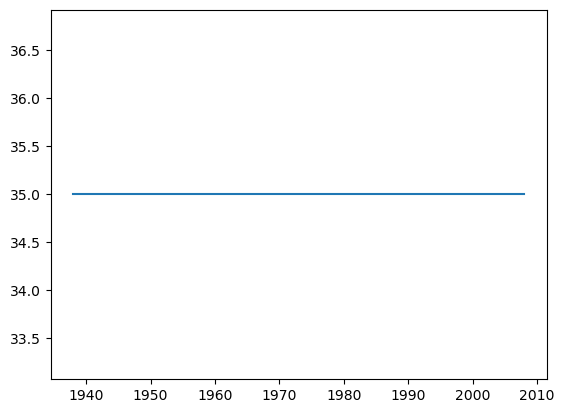

In [105]:
for rm in unique_rms:
    for crop in crops:
        forecast_arima(rm, crop)

In [110]:
import os
from cmdstanpy import CmdStanModel, set_cmdstan_path

# Set the temporary directory for CmdStanPy to a shorter path
os.environ['TMPDIR'] = 'C:\\Users\\jason\\AppData\\Local\\Temp\\tmp2_c_0_y9\\874kriyb.json'

# Check if the temporary directory exists, if not, create it
if not os.path.exists(os.environ['TMPDIR']):
    os.makedirs(os.environ['TMPDIR'])

# Run your forecast_prophet function
forecast_prophet(RMNO, 'Oats')


21:59:27 - cmdstanpy - INFO - Chain [1] start processing
21:59:27 - cmdstanpy - INFO - Chain [1] done processing


38.71688724395125

22:06:08 - cmdstanpy - INFO - Chain [1] start processing
22:06:09 - cmdstanpy - INFO - Chain [1] done processing


71.76353154976299

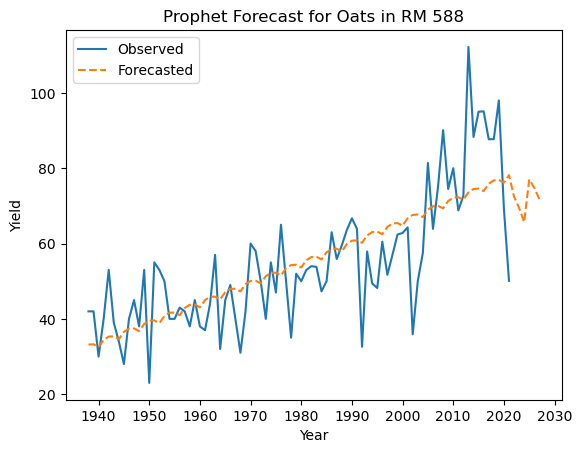

In [116]:
from datetime import datetime

def forecast_prophet(rm, crop, start_year=2022, end_year=2027):
    series = time_series_filled_results[rm][crop].reset_index()
    series.columns = ['ds', 'y']
    
    # Convert years to datetime objects
    series['ds'] = series['ds'].apply(lambda x: datetime(x, 1, 1))
    
    model = Prophet()
    model.fit(series)

    future = model.make_future_dataframe(periods=(end_year - start_year + 1), freq='Y')
    forecast = model.predict(future)

    # Plot the forecast
    fig, ax = plt.subplots()
    ax.plot(series['ds'], series['y'], label='Observed')
    ax.plot(future['ds'], forecast['yhat'], label='Forecasted', linestyle='--')
    ax.set_xlabel('Year')
    ax.set_ylabel('Yield')
    ax.set_title(f'Prophet Forecast for {crop} in RM {rm}')
    plt.legend()
    plt.savefig(f'prophet_forecast_RM_{rm}_Crop_{crop}.png', dpi=300)
    #plt.show()

    # Return the forecast value
    return forecast.iloc[-1]['yhat']

# Example usage
forecast_prophet(RMNO, 'Oats')




In [ ]:
for rm in unique_rms:
    for crop in crops:
        forecast_prophet(rm, crop)


In [118]:
!pip install streamlit

     ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
     ---------------------------------------- 0.1/9.6 MB 656.4 kB/s eta 0:00:15
      --------------------------------------- 0.1/9.6 MB 1.0 MB/s eta 0:00:10
      --------------------------------------- 0.2/9.6 MB 1.1 MB/s eta 0:00:09
     - -------------------------------------- 0.3/9.6 MB 1.4 MB/s eta 0:00:07
     -- ------------------------------------- 0.5/9.6 MB 1.9 MB/s eta 0:00:05
     -- ------------------------------------- 0.5/9.6 MB 1.9 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/9.6 MB 1.9 MB/s eta 0:00:05
     --- ------------------------------------ 0.9/9.6 MB 2.3 MB/s eta 0:00:04
     ---- ----------------------------------- 1.0/9.6 MB 2.4 MB/s eta 0:00:04
     ---- ----------------------------------- 1.1/9.6 MB 2.1 MB/s eta 0:00:05
     ----- ---------------------------------- 1.4/9.6 MB 2.5 MB/s eta 0:00:0

2023-03-18 22:36:16.434 cmd: where.exe tbb.dll
cwd: None
2023-03-18 22:36:16.507 TBB already found in load path
2023-03-18 22:36:16.512 Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2023-03-18 22:36:16.513 Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-03-18 22:36:16.523 input tempfile: C:\Users\jason\AppData\Local\Temp\tmp2_c_0_y9\2hava80o.json
2023-03-18 22:36:16.529 input tempfile: C:\Users\jason\AppData\Local\Temp\tmp2_c_0_y9\omshpp20.json
2023-03-18 22:36:16.532 idx 0
2023-03-18 22:36:16.534 running CmdStan, num_threads: None
2023-03-18 22:36:16.534 CmdStan args: ['C:\\Users\\jason\\anaconda3\\envs\\playground\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=54606', 'data', 'file=C:\\Users\\jason\\AppData\\Local\\Temp\\tmp2_c_0_y9\\2hava80o.json', 'init=C:\\Users\\jason\\AppData\\Local\\Temp\\tmp2_c_0_y9\\omshpp20.json', 'output', 'file=C:\\Users\\jason\\AppData\\Lo

TypeError: forecast_prophet() got an unexpected keyword argument 'plot_fig'

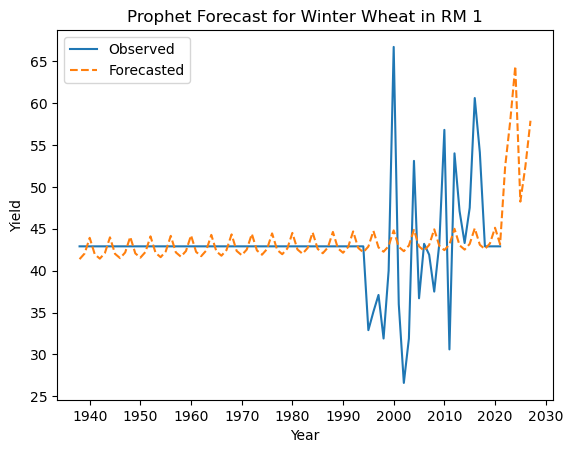

<Figure size 640x480 with 0 Axes>

In [127]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from datetime import datetime

# Load the data
def forecast_prophet(rm, crop, start_year=2022, end_year=2027):
    series = time_series_filled_results[rm][crop].reset_index()
    series.columns = ['ds', 'y']
    
    # Convert years to datetime objects
    series['ds'] = series['ds'].apply(lambda x: datetime(x, 1, 1))
    
    model = Prophet()
    model.fit(series)

    future = model.make_future_dataframe(periods=(end_year - start_year + 1), freq='Y')
    forecast = model.predict(future)

    # Plot the forecast
    fig, ax = plt.subplots()
    ax.plot(series['ds'], series['y'], label='Observed')
    ax.plot(future['ds'], forecast['yhat'], label='Forecasted', linestyle='--')
    ax.set_xlabel('Year')
    ax.set_ylabel('Yield')
    ax.set_title(f'Prophet Forecast for {crop} in RM {rm}')
    plt.legend()
    plt.savefig(f'prophet_forecast_RM_{rm}_Crop_{crop}.png', dpi=300)
    #plt.show()

    # Return the forecast value
    return forecast.iloc[-1]['yhat']

st.title("Crop Yield Forecast")

# User input for RM and crop
rm = st.selectbox("Select RM:", unique_rms)  # Replace list_of_rms with a list of available RM numbers
crop = st.selectbox("Select crop:", crops)

# Forecasting
forecast_value = forecast_prophet(rm, crop)

# Display the forecast
st.write(f"Forecasted yield for {crop} in RM {rm}: {forecast_value:.2f}")

# Display the plot
fig = plt.figure()
# Generate the plot using the modified forecast_prophet function
forecast_prophet(rm, crop, plot_fig=fig)
st.pyplot(fig)



In [128]:
streamlit run app.py

SyntaxError: invalid syntax (3737097518.py, line 1)